In [1]:
# finance datareader가 설치 안되어 있을시 실행
# !pip install finance-datareader

In [11]:
import os 
from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import FinanceDataReader as fdr
import numpy as np
import pandas_datareader as pdr

## 시가 총액과 데이터 가져오기

In [3]:
# 처음 실행시만 한번 돌려보기
# !git clone "https://github.com/FinanceData/marcap.git" marcap

In [4]:
idx = pd.IndexSlice

In [5]:
data_path = Path('marcap', 'data')

In [6]:
file_list = os.listdir(data_path)

In [7]:
data_list = []
for file in file_list:
    file_path = data_path / file 
    data = pd.read_csv(file_path, dtype={'Code':str}, parse_dates=['Date'])
    data_list.append(data) 

C:\Users\PC\anaconda3\envs\ml4t_orginal\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
data = pd.concat(data_list)

In [9]:
# KOSPI 종목만 출력
kospi_data = data[data.Market == 'KOSPI']
kospi_data.rename(columns=str.lower, inplace=True)

kospi_data = kospi_data[['code','close','open', 'high', 'low', 'volume', 'amount', 'marcap','date', 'stocks']]
kospi_data.rename(columns={'code': 'ticker'}, inplace=True)

C:\Users\PC\anaconda3\envs\ml4t_orginal\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [10]:
kospi_data = kospi_data.groupby(['date', 'ticker']).last()

## 상장폐지 데이터 추가
- 데이터의 생존 편향을 없애기 위해서 상장 폐지 데이터도 추가해줘야 된다.

In [11]:
## 상장폐지 데이터 가져오기
delisting_data = fdr.StockListing('KRX-DELISTING')

#### 데이터 확인

In [12]:
delisting_data.head(10)

,Symbol,Name,Market,SecuGroup,Kind,ListingDate,DelistingDate,Reason,ArrantEnforceDate,ArrantEndDate,Industry,ParValue,ListingShares,ToSymbol,ToName
0,06031012,3S R,KOSDAQ,신주인수권증서,보통주,2012-05-14,2012-05-21,,NaT,NaT,,0.0,1194422.0,,
1,00684014,AK홀딩스8R,KOSPI,신주인수권증서,보통주,2014-07-28,2014-08-04,,NaT,NaT,,0.0,1278299.0,,
2,13893015,BNK금융지주 8R,KOSPI,신주인수권증서,보통주,2015-12-24,2016-01-05,,NaT,NaT,,0.0,55969410.0,,
3,13893014,BS금융지주5R,KOSPI,신주인수권증서,보통주,2014-06-18,2014-06-25,,NaT,NaT,,0.0,32791220.0,,
4,03204017,C&S자산관리 34R,KOSDAQ,신주인수권증서,보통주,2017-02-02,2017-02-09,,NaT,NaT,,0.0,3995063.0,,
5,0791601A,CJ CGV 5R,KOSPI,신주인수권증서,보통주,2020-07-03,2020-07-10,,NaT,NaT,,0.0,11123742.0,,
6,001047,CJ2우B,KOSPI,주권,신형우선주,1999-01-29,2009-03-21,,NaT,NaT,서비스업,5000.0,1019041.0,,
7,001049,CJ3우B,KOSPI,주권,신형우선주,2000-01-28,2010-01-13,,NaT,NaT,서비스업,5000.0,533173.0,,
8,097957,CJ제일제당 2우B,KOSPI,주권,신형우선주,2007-09-28,2009-03-21,,NaT,NaT,음식료품,5000.0,598485.0,,
9,097959,CJ제일제당 3우B,KOSPI,주권,신형우선주,2007-09-28,2010-01-13,,NaT,NaT,음식료품,5000.0,313133.0,,


데이터 구조를 확인하고 어떤 데이터가 필요한지 생각해본다.
+ KOSPI 종목 데이터
+ 우선주 제외 
+ ETF 제외 
+ 기타 하나로스펙 5호같은 회사들 제외 

#### SecuGroup을 확인

In [13]:
delisting_data.SecuGroup.unique()

array(['신주인수권증서', '주권', '신주인수권증권', '수익증권', '투자회사', '선박투자회사', '외국주권',
       '부동산투자회사', '주식예탁증권'], dtype=object)

데이터중 투자회사 데이터가 뭔지 확인 -> 나머지도 투자회사에서 수익증권 이렇게 코드 바꿔가면서 어떤 데이터 인지 확인 

In [14]:
delisting_data[delisting_data.SecuGroup == '투자회사'].head(5)

,Symbol,Name,Market,SecuGroup,Kind,ListingDate,DelistingDate,Reason,ArrantEnforceDate,ArrantEndDate,Industry,ParValue,ListingShares,ToSymbol,ToName
654,099340,하나니켈1호,KOSPI,투자회사,보통주,2008-02-01,2020-07-01,존속기간 만료,NaT,NaT,기타금융,NaN,22756200.0,,
655,099350,하나니켈2호,KOSPI,투자회사,보통주,2008-02-01,2020-07-01,존속기간 만료,NaT,NaT,기타금융,NaN,3284000.0,,
1196,098150,한국아태특별,KOSPI,투자회사,보통주,2007-09-05,2012-04-23,해산 사유 발생,NaT,NaT,기타금융,NaN,7328373.0,,
1218,093820,한국유전15-1,KOSPI,투자회사,보통주,2007-01-02,2012-02-01,해산 사유 발생,NaT,NaT,기타금융,NaN,40820000.0,,
1234,094520,맵스베트남1,KOSPI,투자회사,보통주,2007-02-01,2011-11-24,신청에 의한 상장폐지,NaT,NaT,기타금융,NaN,24360821.0,,


In [15]:
delisting_data[delisting_data.SecuGroup == '주권'].tail(5)

,Symbol,Name,Market,SecuGroup,Kind,ListingDate,DelistingDate,Reason,ArrantEnforceDate,ArrantEndDate,Industry,ParValue,ListingShares,ToSymbol,ToName
3224,034370,럭키소재,KOSPI,주권,,1979-06-23,1991-11-11,해산 사유 발생,NaT,NaT,,NaN,NaN,,
3225,028460,태평양건설,KOSPI,주권,,1977-06-09,1991-10-05,영업활동정지 6월 계속,1991-08-28,1991-10-04,,NaN,NaN,,
3226,028450,금성투자금융,KOSPI,주권,,1986-08-29,1991-09-02,해산 사유 발생,NaT,NaT,,NaN,NaN,,
3227,028440,삼화,KOSPI,주권,,1974-06-12,1991-07-12,감사의견 의견거절,1991-06-05,1991-07-11,,NaN,NaN,,
3228,029260,금성전기,KOSPI,주권,,1976-06-29,1991-06-13,해산 사유 발생,NaT,NaT,,NaN,NaN,,


### 우리가 분석하는데 필요한 데이터 생각
1. 신주인수권증서
2. 주권
3. 신주인수권증권
4. 수익증권
5. 투자회사
6. 선박투자회사
7. 외국주권
8. 부동산투자회사
9. 주식예탁증권 

중에서 


2. 주권 인것을 알 수 있다.

In [16]:
## KOSPI 데이터와 주권 데이터를 가져오기
delisting_data = delisting_data[(delisting_data.Market == 'KOSPI') & (delisting_data.SecuGroup == '주권')]

In [17]:
# 최근 KOSPI에 상장되어 있는 회사 이름 가져오기
kospi = fdr.StockListing('Kospi')
kospi_name = pd.Index(kospi['Name'])

In [18]:
# 상장폐지된 회사 데이터의 회사이름 데이터 가져오기
delisting_name = pd.Index(delisting_data.Name)

In [19]:
# 같은 이름인데 최근 KOSPI 회사 이름이랑 상장폐지된 데이터 회사이름이랑 겹치는 데이터가 있다. (아마 재상장 같은 상황)
# 최근 상장되어 있는 데이터 이름과 겹치는 이름 제거
delisting_name = delisting_name.difference(kospi_name)

In [20]:
# 상장폐지가 되었고 최근 상장된 회사들과 이름이 안겹치는 종목들 추출
delisting_name

Index(['AP우주통신', 'AP우주통신(1우B)', 'BHK', 'C&상선', 'C&우방', 'C&중공업', 'C&중공업우',
       'CJ2우B', 'CJ3우B', 'CJ제일제당 2우B',
       ...
       '화성산업4우', '화성산업우', '화인자산관리', '환영철강', '효성물산', '훈영', '휴닉스', '휴닉스(1우)',
       '휴리프', '흥양'],
      dtype='object', name='Name', length=650)

In [21]:
delisting_data = delisting_data[delisting_data.Name.isin(delisting_name)]

In [22]:
delisting_data

,Symbol,Name,Market,SecuGroup,Kind,ListingDate,DelistingDate,Reason,ArrantEnforceDate,ArrantEndDate,Industry,ParValue,ListingShares,ToSymbol,ToName
6,001047,CJ2우B,KOSPI,주권,신형우선주,1999-01-29,2009-03-21,,NaT,NaT,서비스업,5000.0,1019041.0,,
7,001049,CJ3우B,KOSPI,주권,신형우선주,2000-01-28,2010-01-13,,NaT,NaT,서비스업,5000.0,533173.0,,
8,097957,CJ제일제당 2우B,KOSPI,주권,신형우선주,2007-09-28,2009-03-21,,NaT,NaT,음식료품,5000.0,598485.0,,
9,097959,CJ제일제당 3우B,KOSPI,주권,신형우선주,2007-09-28,2010-01-13,,NaT,NaT,음식료품,5000.0,313133.0,,
41,002105,경농(1우),KOSPI,주권,구형우선주,1995-03-21,2005-03-28,,NaT,NaT,화학,5000.0,336.0,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3224,034370,럭키소재,KOSPI,주권,,1979-06-23,1991-11-11,해산 사유 발생,NaT,NaT,,NaN,NaN,,
3225,028460,태평양건설,KOSPI,주권,,1977-06-09,1991-10-05,영업활동정지 6월 계속,1991-08-28,1991-10-04,,NaN,NaN,,
3226,028450,금성투자금융,KOSPI,주권,,1986-08-29,1991-09-02,해산 사유 발생,NaT,NaT,,NaN,NaN,,
3227,028440,삼화,KOSPI,주권,,1974-06-12,1991-07-12,감사의견 의견거절,1991-06-05,1991-07-11,,NaN,NaN,,


Kind에 유니크한 값들을 확인해보면 신형우선주, 구형 우선주, 보통주와 아무것도 없는 ''이 있는것을 알 수 있다.

In [23]:
delisting_data.Kind.unique()

array(['신형우선주', '구형우선주', '', '보통주'], dtype=object)

#### ' ' 데이터 확인
- ' '로 분류해놓은 이유 추측
     + 상장은 폐지되었지만 너무 오랜된 데이터들은 ''로 표시되는거 같다.
     + 1995년을 기준으로 그전에 상폐는 ' ' 이후 상폐는 Kind에 보통주로 표기 비교는 밑에 있음

In [24]:
delisting_data[delisting_data.Kind == '']

,Symbol,Name,Market,SecuGroup,Kind,ListingDate,DelistingDate,Reason,ArrantEnforceDate,ArrantEndDate,Industry,ParValue,ListingShares,ToSymbol,ToName
138,016165,라딕스우,KOSPI,주권,,1989-06-26,1991-04-27,,NaT,NaT,,NaN,NaN,,
206,014905,삼보컴퓨터우,KOSPI,주권,,1989-12-19,1990-09-18,,NaT,NaT,,NaN,NaN,,
227,011965,새한종금우,KOSPI,주권,,1989-10-16,1991-11-16,,NaT,NaT,,NaN,NaN,,
557,001757,한양증권2우,KOSPI,주권,,1989-10-24,1994-03-30,,NaT,NaT,,NaN,NaN,,
596,002467,화성산업2우,KOSPI,주권,,1990-02-06,1993-04-21,,NaT,NaT,,NaN,NaN,,
597,002469,화성산업3우,KOSPI,주권,,1991-05-22,1994-04-23,,NaT,NaT,,NaN,NaN,,
598,00246A,화성산업4우,KOSPI,주권,,1992-05-25,1995-04-21,,NaT,NaT,,NaN,NaN,,
599,002465,화성산업우,KOSPI,주권,,1990-01-22,1992-04-21,,NaT,NaT,,NaN,NaN,,
3189,006270,금성통신,KOSPI,주권,,1974-07-31,1995-03-23,해산 사유 발생,NaT,NaT,,NaN,NaN,,
3190,006275,금성통신우,KOSPI,주권,,1988-07-18,1995-03-23,해산 사유 발생,NaT,NaT,,NaN,NaN,,


#### 보통주 데이터 확인
- 비교적 최근에 상장폐지된 회사들인것을 알 수 있다.

In [25]:
delisting_data[delisting_data.Kind == '보통주'].head(5)

,Symbol,Name,Market,SecuGroup,Kind,ListingDate,DelistingDate,Reason,ArrantEnforceDate,ArrantEndDate,Industry,ParValue,ListingShares,ToSymbol,ToName
613,005190,동성화학,KOSPI,주권,보통주,1988-07-01,2021-04-16,해산 사유 발생,NaT,NaT,화학,1000.0,5335564.0,,
634,152330,코리아오토글라스,KOSPI,주권,보통주,2015-12-29,2020-12-18,해산 사유 발생,NaT,NaT,비금속광물,5000.0,20000000.0,,
648,004200,고려개발,KOSPI,주권,보통주,1978-10-30,2020-07-21,해산 사유 발생,NaT,NaT,건설업,5000.0,15219444.0,,
650,002300,한국제지,KOSPI,주권,보통주,1971-06-23,2020-07-13,해산 사유 발생,NaT,NaT,종이목재,5000.0,5004949.0,,
656,005450,신한,KOSPI,주권,보통주,1978-07-28,2020-06-30,감사의견 의견거절 2년 계속,2020-06-19,2020-06-29,건설업,5000.0,7022839.0,,


In [26]:
# 보통주만 출력
delisting_common_stock_data = delisting_data[delisting_data.Kind == '보통주']

In [27]:
# Multi Thread Pool을 이용해서 데이터 가져오는 속도 올리기
from concurrent import futures
import concurrent

In [28]:
code_list = delisting_common_stock_data.Symbol.to_list()

In [29]:
data_list = []

error_stock_list = []
def get_delisting_data(code: str):
    try:
        data = fdr.DataReader(code, exchange='KRX-DELISTING')
        data = data.loc[:,['Date', 'Code', 'Close', 'Open', 'High','Lower', 'Volume', 'Amount','MarCap']]
        data['Stocks'] = data['MarCap'] / data['Close']
        data.rename(columns=str.lower, inplace=True)
        data.rename(columns={'code':'ticker', 'lower':'low'}, inplace=True)
        data_list.append(data.copy())
    except Exception as e:
        error_stock_list.append(code)
        
with futures.ThreadPoolExecutor(50) as executor:
    executor.map(get_delisting_data, code_list)

In [30]:
delisting_stock_data = pd.concat(data_list)

In [31]:
delisting_stock_data

,date,ticker,close,open,high,low,volume,amount,marcap,stocks
0,2020-02-13,079440,27500,0,0,0,0,0,2255000000000,82000000.0
1,2020-02-12,079440,27500,0,0,0,0,0,2255000000000,82000000.0
2,2020-02-11,079440,27500,0,0,0,0,0,2255000000000,82000000.0
3,2020-02-10,079440,27500,0,0,0,0,0,2255000000000,82000000.0
4,2020-02-07,079440,27500,0,0,0,0,0,2255000000000,82000000.0
...,...,...,...,...,...,...,...,...,...,...
6376,1995-05-08,005450,9300,9230,9500,9230,35310,329974900,72615906600,7808162.0
6377,1995-05-06,005450,9330,9500,9550,9300,25340,238137100,72850151460,7808162.0
6378,1995-05-04,005450,9550,9550,9860,9500,74420,722229600,74567947100,7808162.0
6379,1995-05-03,005450,9660,9520,9800,9450,167210,1601603400,75426844920,7808162.0


### Error나서 데이터 못가져오는 상장폐지 종목들 저장 (추후 다른 Data Provider 선정을 위해)

In [32]:
error_data = delisting_data[delisting_data.Symbol.isin(error_stock_list)]

In [33]:
error_data.to_csv('delisting_stock_error.csv')

## ETF, 우선주 제외한 KOSPI 종목 데이터 가져오기

In [34]:
kospi.head(5)

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,박대현,http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
6,152100,KOSPI,ARIRANG 200,NaN,NaN,NaT,NaN,NaN,NaN,NaN
7,295820,KOSPI,ARIRANG 200동일가중,NaN,NaN,NaT,NaN,NaN,NaN,NaN
8,253150,KOSPI,ARIRANG 200선물레버리지,NaN,NaN,NaT,NaN,NaN,NaN,NaN


In [35]:
kospi.dropna(subset=['Sector'], inplace=True)

In [36]:
ticker = kospi.Symbol

In [37]:
# 우선주, ETF 제외하고 남은 종목들 추출
# 이 테스크는 시간이 오래걸립니다.
kospi_data = kospi_data.loc[idx[:, ticker],:]

In [38]:
kospi_data = kospi_data.reorder_levels(['date','ticker']).sort_index()

## 최근 KOSPI 데이터에  상장폐지 데이터 추가

In [39]:
kospi_data.reset_index(inplace=True)

In [40]:
kospi_data.head(5)

,date,ticker,close,open,high,low,volume,amount,marcap,stocks
0,1995-05-02,000020,29200.0,29300.0,29300.0,29200.0,1500.0,4.390000e+07,7.679600e+10,2630000
1,1995-05-02,000040,7500.0,7300.0,7500.0,7300.0,7970.0,5.917060e+07,2.482676e+10,3310235
2,1995-05-02,000050,55100.0,55100.0,55100.0,55100.0,10.0,5.510000e+05,8.485400e+10,1540000
3,1995-05-02,000060,18900.0,18200.0,18900.0,18100.0,79680.0,1.477424e+09,1.621620e+11,8580000
4,1995-05-02,000070,31300.0,29800.0,32900.0,29800.0,5950.0,1.871460e+08,2.478960e+11,7920000


In [41]:
delisting_stock_data.tail(5)

,date,ticker,close,open,high,low,volume,amount,marcap,stocks
6376,1995-05-08,005450,9300,9230,9500,9230,35310,329974900,72615906600,7808162.0
6377,1995-05-06,005450,9330,9500,9550,9300,25340,238137100,72850151460,7808162.0
6378,1995-05-04,005450,9550,9550,9860,9500,74420,722229600,74567947100,7808162.0
6379,1995-05-03,005450,9660,9520,9800,9450,167210,1601603400,75426844920,7808162.0
6380,1995-05-02,005450,9320,8900,9320,8900,41060,375628900,72772069840,7808162.0


In [42]:
kospi_data = pd.concat([kospi_data, delisting_stock_data])

In [43]:
kospi_data = kospi_data.groupby(['date', 'ticker']).last()

In [44]:
kospi_data

close      open      high       low     volume  \
date       ticker                                                      
1995-05-02 000020   29200.0   29300.0   29300.0   29200.0     1500.0   
           000040    7500.0    7300.0    7500.0    7300.0     7970.0   
           000050   55100.0   55100.0   55100.0   55100.0       10.0   
           000060   18900.0   18200.0   18900.0   18100.0    79680.0   
           000070   31300.0   29800.0   32900.0   29800.0     5950.0   
...                     ...       ...       ...       ...        ...   
2021-05-21 378850    6290.0    6520.0    6650.0    6210.0   141490.0   
           380440    2100.0    2075.0    2120.0    2045.0  9327020.0   
           383220  412500.0  360000.0  468000.0  360000.0   553415.0   
           900140    3560.0    3565.0    3620.0    3540.0   256111.0   
           950210   28800.0   29200.0   29300.0   28800.0   236888.0   

                         amount        marcap      stocks  
date       ticker                                          
1995-05-02 000020  4.390000e+07  7.679600e+10   2630000.0  
           000040  5.917060e+07  2.482676e+10   3310235.0  
           000050  5.510000e+05  8.485400e+10   1540000.0  
           000060  1.477424e+09  1.621620e+11   8580000.0  
           000070  1.871460e+08  2.478960e+11   7920000.0  
...                         ...           ...         ...  
2021-05-21 378850  9.072490e+08  1.194699e+11  18993623.0  
           380440  1.931229e+10  1.077090e+11  51290000.0  
           383220  2.391376e+11  3.160334e+12   7661415.0  
           900140  9.139745e+08  3.540609e+11  99455297.0  
           950210  6.868418e+09  1.730769e+12  60096155.0  

[3869985 rows x 8 columns]

## ETF, 우선주가 제외돼고 상장폐지 데이터가 추가되었으므로 시가총액 순위를 다시 구해줘야 된다.

In [45]:
marcap_data = kospi_data['marcap'].to_frame()

In [46]:
marcap_data = marcap_data.unstack('date')

In [47]:
rank_data = marcap_data.rank(ascending=False)

In [48]:
rank_data.rename(columns={'marcap':'rank'}, inplace=True)

In [49]:
kospi_data = kospi_data.unstack('date')

In [50]:
kospi_data = pd.concat([kospi_data, rank_data], axis=1)

In [51]:
kospi_data = kospi_data.stack('date')

## 데이터 타입 변경으로 데이터 프레임 메모리 최소화

In [52]:
# rank도 타입을 정해줘서 메모리 최소화
kospi_data = kospi_data.astype({'close':'int32', 'high':'int32', 'low':'int32', 'open':'int32', 'volume':'int32', 'stocks':'int64', 'amount':'int64', 'marcap':'int64', 'rank':'int16'})

In [53]:
kospi_data = kospi_data.reorder_levels(['date','ticker']).sort_index()

## 수정 종가 계산

In [54]:
close_data = kospi_data['close'].unstack('ticker')

In [55]:
stock_data = kospi_data['stocks'].unstack('ticker')

In [56]:
lag_stock_data = stock_data.iloc[-1].to_frame().T

In [57]:
adj_close_data = close_data * (stock_data / lag_stock_data.iloc[0])

In [58]:
kospi_data['adj_close'] = adj_close_data.stack('ticker')

## 수정 시가 계산

+ 계산 방법은 가격이 1000원이던 주식 100주가 액면분활해서 최근에 10050원 10주가 되었다.
    - (과거 보통주 / 최근 보통주) * 가격
    - e.g) (100 / 10) * 1000 = 10000

In [59]:
open_data = kospi_data['open'].unstack('ticker')

In [60]:
adj_open_data = open_data * (stock_data / lag_stock_data.iloc[0])

In [61]:
kospi_data['adj_open'] = adj_open_data.stack('ticker')

## 수정 고가 계산

In [62]:
high_data = kospi_data['high'].unstack('ticker')
adj_high_data = high_data * (stock_data / lag_stock_data.iloc[0])
kospi_data['adj_high'] = adj_high_data.stack('ticker')

## 수정 저가 계산

In [63]:
low_data = kospi_data['low'].unstack('ticker')
adj_low_data = low_data * (stock_data / lag_stock_data.iloc[0])
kospi_data['adj_low'] = adj_low_data.stack('ticker')

## 수정 거래량

In [64]:
volume_data = kospi_data['volume'].unstack('ticker')
adj_volume_data = volume_data * (lag_stock_data.iloc[0] / stock_data)
kospi_data['adj_volume'] = adj_volume_data.stack('ticker')

#### 삼성전자를 기준으로 제대로 계산되었는지 Plot

In [65]:
samsung_data = kospi_data.loc[idx[:,'005930'], :]

In [66]:
col_list = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']

In [67]:
def plot(column_name: str):
    x = samsung_data.index.get_level_values(0)
    y = samsung_data[column_name]
    plt.plot(x, y)
    plt.show()

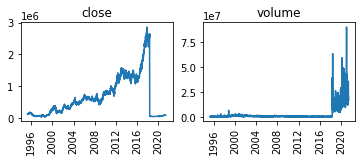

No handles with labels found to put in legend.


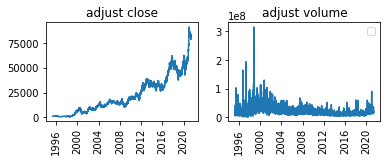

In [68]:
import matplotlib.pyplot as plt

x = samsung_data.index.get_level_values(0)
y = samsung_data['close']
plt.subplot(2,2,1)
plt.plot(x, y)
plt.xticks(rotation='vertical')
plt.title('close')

y = samsung_data['volume']
plt.subplot(2,2,2)
plt.plot(x, y)
plt.title('volume')
plt.xticks(rotation='vertical')
plt.show()

y = samsung_data['adj_close']
plt.subplot(2,2,3)
plt.plot(x, y)
plt.xticks(rotation='vertical')
plt.title('adjust close')

y = samsung_data['adj_volume']
plt.subplot(2,2,4)
plt.plot(x, y)
plt.title('adjust volume')
plt.xticks(rotation='vertical')

plt.legend()
plt.show()

## Data 저장 위치 설정

In [29]:
DATA_STORE = Path('assets.h5')

## 수정주가 중에서 이상치 제거

In [70]:
return_data = kospi_data[['marcap']].unstack('ticker').fillna(method='bfill').pct_change().stack('ticker')

In [71]:
return_array = return_data['marcap'].to_numpy()

### 수익률 하위, 상위 0.003%  값들 출력 Outlier 제거
- e.g) 수익률이 -10, -1, 0, 0, 1, 20, 10, -5, 0, 14 이면 하위 10% 확률로 -10% 손실이 나고 90% 확률로 수익 20%난다.

In [72]:
buffer = 0.003
up = np.percentile(return_array, 100 - buffer)
down = np.percentile(return_array, buffer)
print(f"수익률 상위:{100- buffer}% 확률로 수익률: {up}%")
print(f"수익률 하위:{buffer}% 확률로 수익률: {down}%")

수익률 상위:99.997% 확률로 수익률: 2.075325500569362%
수익률 하위:0.003% 확률로 수익률: -0.4276601419184662%


In [73]:
down_index = return_data[return_data.marcap < down].index.get_level_values('ticker').unique()

In [74]:
up_index = return_data[return_data.marcap > up].index.get_level_values('ticker').unique()

In [75]:
# 수익률 하위랑 상위 걸러야 되는 종목코드 배열 합치기
# 제외할 종목들 할당
exclude_index = up_index.append(down_index).unique()

In [76]:
cleaning_ticker = kospi_data.index.get_level_values('ticker').unique().difference(exclude_index)

In [77]:
kospi_data = kospi_data.loc[idx[:, cleaning_ticker],:]

## 가격 데이터 저장

In [78]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('finance_datareader/prices', kospi_data)

## 회사 코드랑 이름 저장

In [79]:
kospi_stock = kospi[['Symbol','Name']]

In [80]:
kospi_stock.columns = ['code', 'name']

In [81]:
kospi_stock.set_index('code', inplace=True)

In [82]:
kospi_stock

,name
code,
095570,AJ네트웍스
006840,AK홀딩스
027410,BGF
282330,BGF리테일
138930,BNK금융지주
...,...
079980,휴비스
005010,휴스틸
069260,휴켐스


In [83]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('finance_datareader/stocks', kospi_stock)

## BenchMark로 설정할 KOPSI Index 데이터

In [24]:
kospi_price = pdr.DataReader('^KS11', 'yahoo', start='1994')

In [25]:
kospi_price

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1996-12-11,709.479980,704.429993,705.989990,704.679993,28000.0,704.679993
1996-12-12,706.010010,688.739990,705.109985,689.380005,25900.0,689.380005
1996-12-13,695.719971,677.640015,690.440002,689.070007,26500.0,689.070007
1996-12-16,686.969971,667.710022,686.969971,673.919983,22800.0,673.919983
1996-12-17,680.090027,660.390015,675.349976,663.349976,31600.0,663.349976
...,...,...,...,...,...,...
2021-05-21,3198.010010,3149.459961,3171.909912,3156.419922,796800.0,3156.419922
2021-05-24,3163.270020,3137.810059,3155.909912,3144.300049,587500.0,3144.300049
2021-05-25,3173.100098,3148.300049,3152.929932,3171.320068,612700.0,3171.320068


In [26]:
kospi_price.rename(columns=str.lower, inplace=True)

In [27]:
kospi_price.index.names = ['date']

In [31]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('pandas_datareader/kospi', kospi_price)

## 코스피 회사 데이터 저장

In [ ]:
kospi.rename(columns=str.lower, inplace=True)
kospi.set_index('symbol', inplace=True)

In [ ]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('kospi/stocks', kospi)